In [1]:
# Install catalax
# !pip install catalax

In [1]:
import json
import jax.numpy as jnp
import numpy as np

import catalax as ctx

import brainunit as u

In [2]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

def f(t, y, args):
    K_m, v_max  = args
    s1 = y * (u.molar / u.katal)
    d_s1 = - (v_max * s1) / (K_m + s1)
    return d_s1 / u.second

# Add term
model.add_term(f)

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0 * u.katal
model.parameters.K_m.value = 100.0 * u.molar

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[v_max, K_m]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100. * molar,False,None,None,None,None
1,v_max,v_max,7. * katal,False,None,None,None,None


In [3]:

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
n_ds = 30

time = jnp.array([
    *[[10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 120],]*n_ds
]) * u.second

# Set initial conditions above and below the
# true Km value for the sake of the example
initial_conditions = []

for _ in range(n_ds):
    initial_conditions += [
        {"s1": np.random.normal(300.0, 8.0) * u.katal},
        {"s1": np.random.normal(200.0, 8.0) * u.katal},
        {"s1": np.random.normal(80.0, 8.0) * u.katal},
        {"s1": np.random.normal(50.0, 8.0) * u.katal},
    ]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1 * u.second, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
data = np.random.normal(data.to_decimal(u.katal), 1.0).clip(min=0) * u.katal

# Turn intiial conditions into a matrix (Not yet part of the NeuralODE workflow)
y0s = model._assemble_y0_array(initial_conditions, in_axes=(0, None, None))


print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")

Time: (120, 6) | Data: (120, 6, 1) | Initial Conditions: (120, 1)


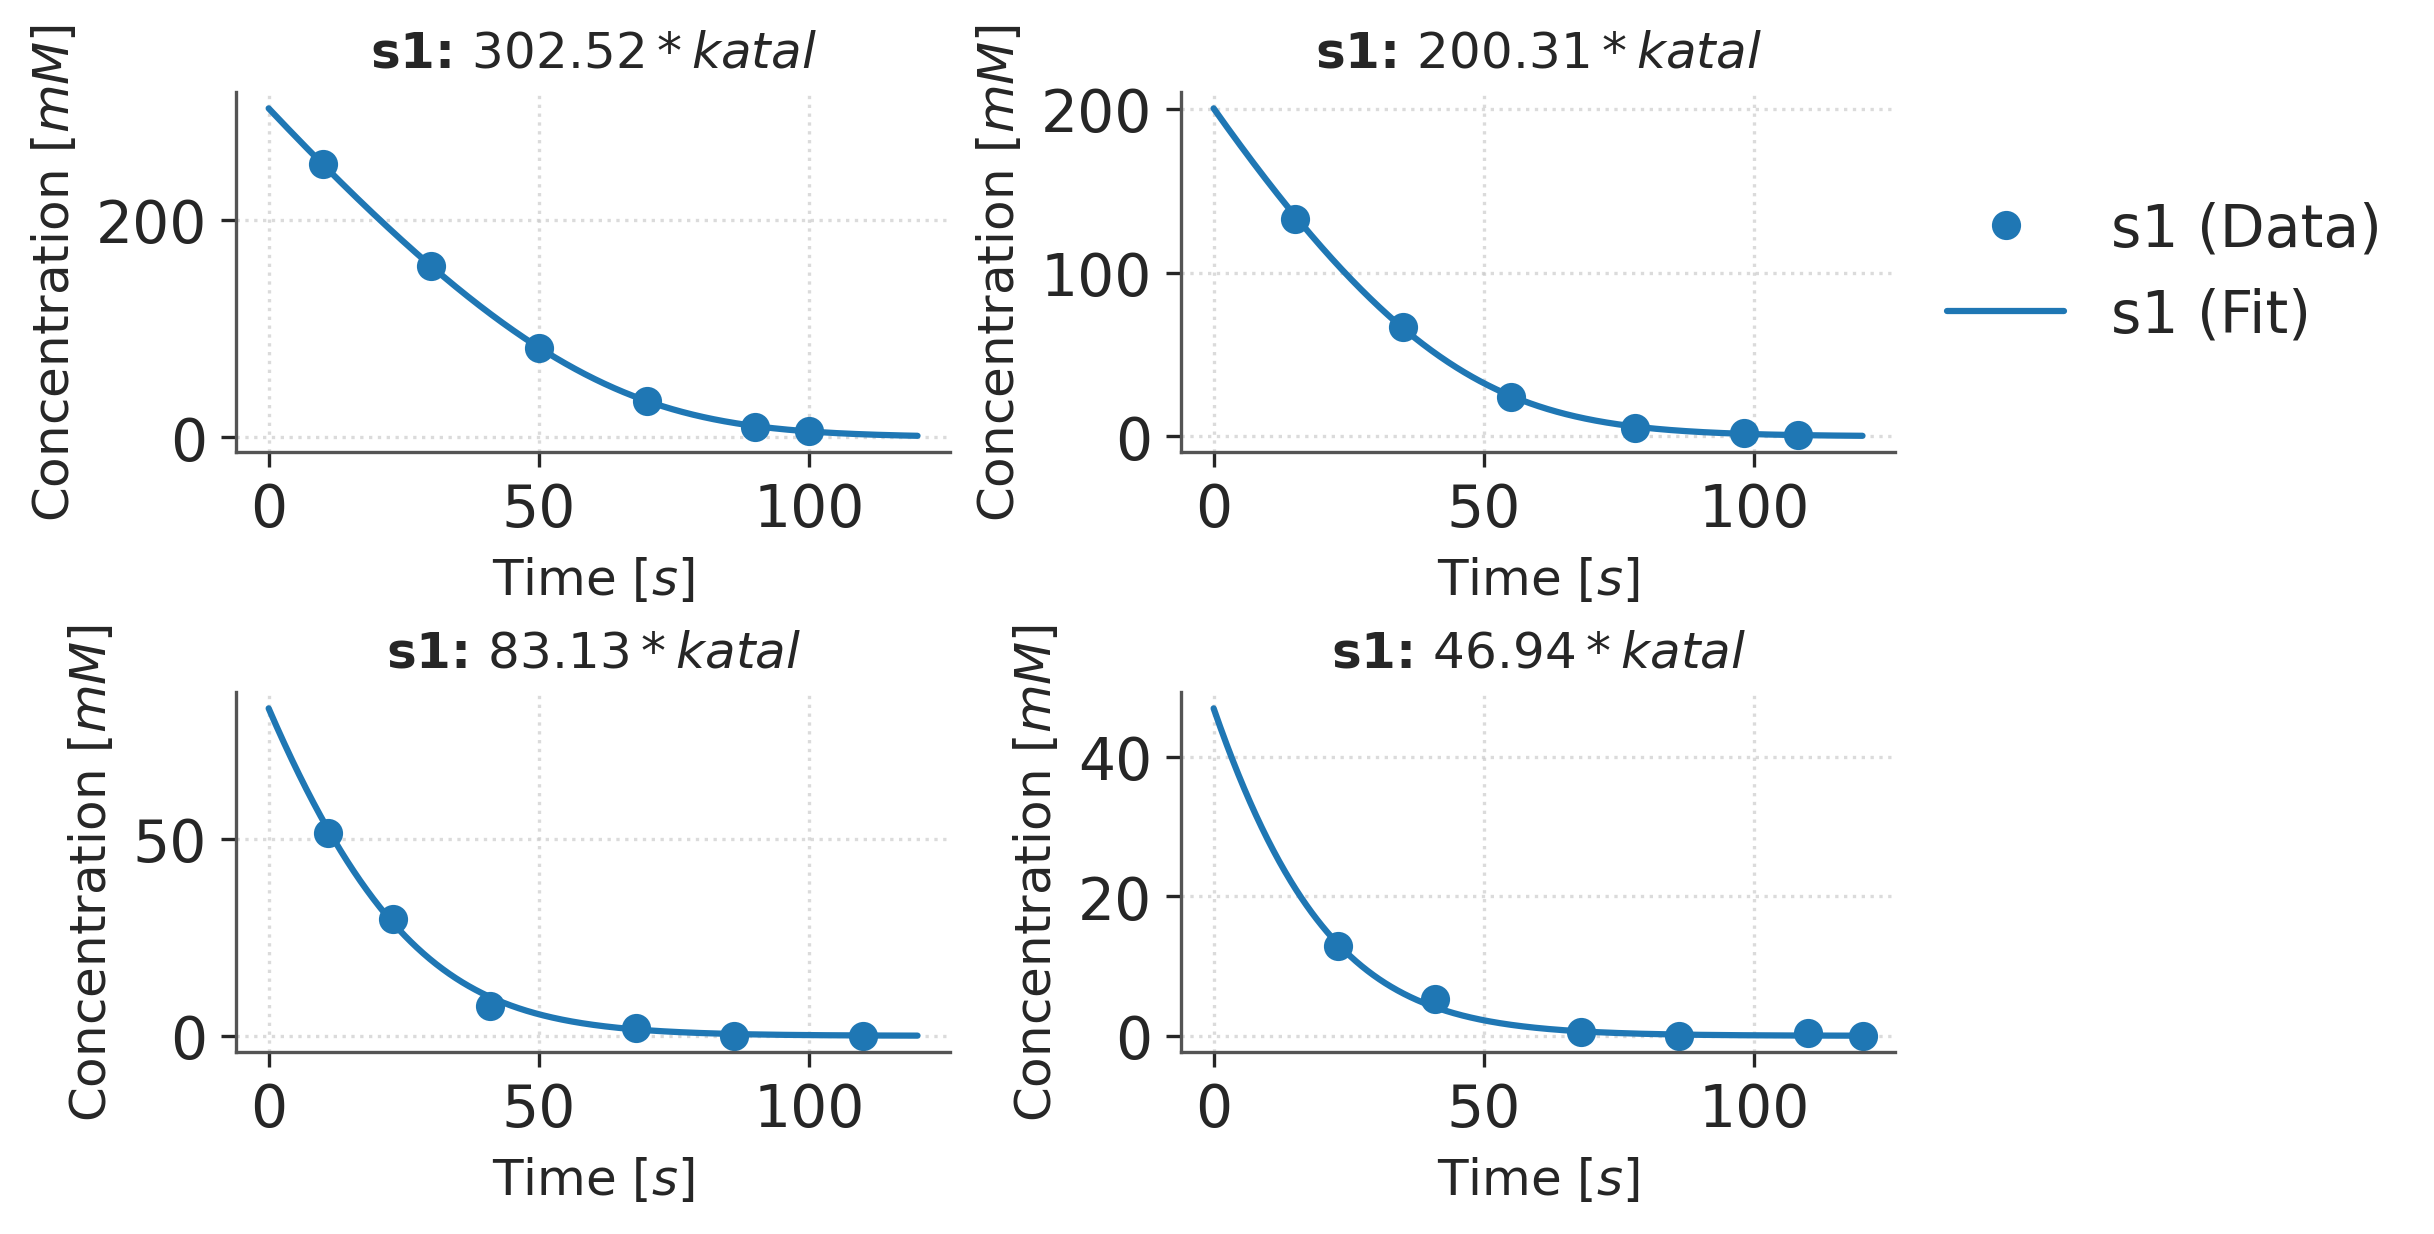

In [4]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)

In [5]:
# In order to perform optimization, we need to add initial values.
model.parameters.v_max.initial_value = 10.0 * u.katal
model.parameters.K_m.initial_value = 120.0 * u.molar

# ... and to make sure to be as realistic as possible.
model.parameters.v_max.value = None
model.parameters.K_m.value = None

In [6]:
# Perform the optimization
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

UnitMismatchError: Cannot compare 10.0 * katal > 100000.0 * Unit(10.0^0), since units do not match: kat != Unit(10.0^0)

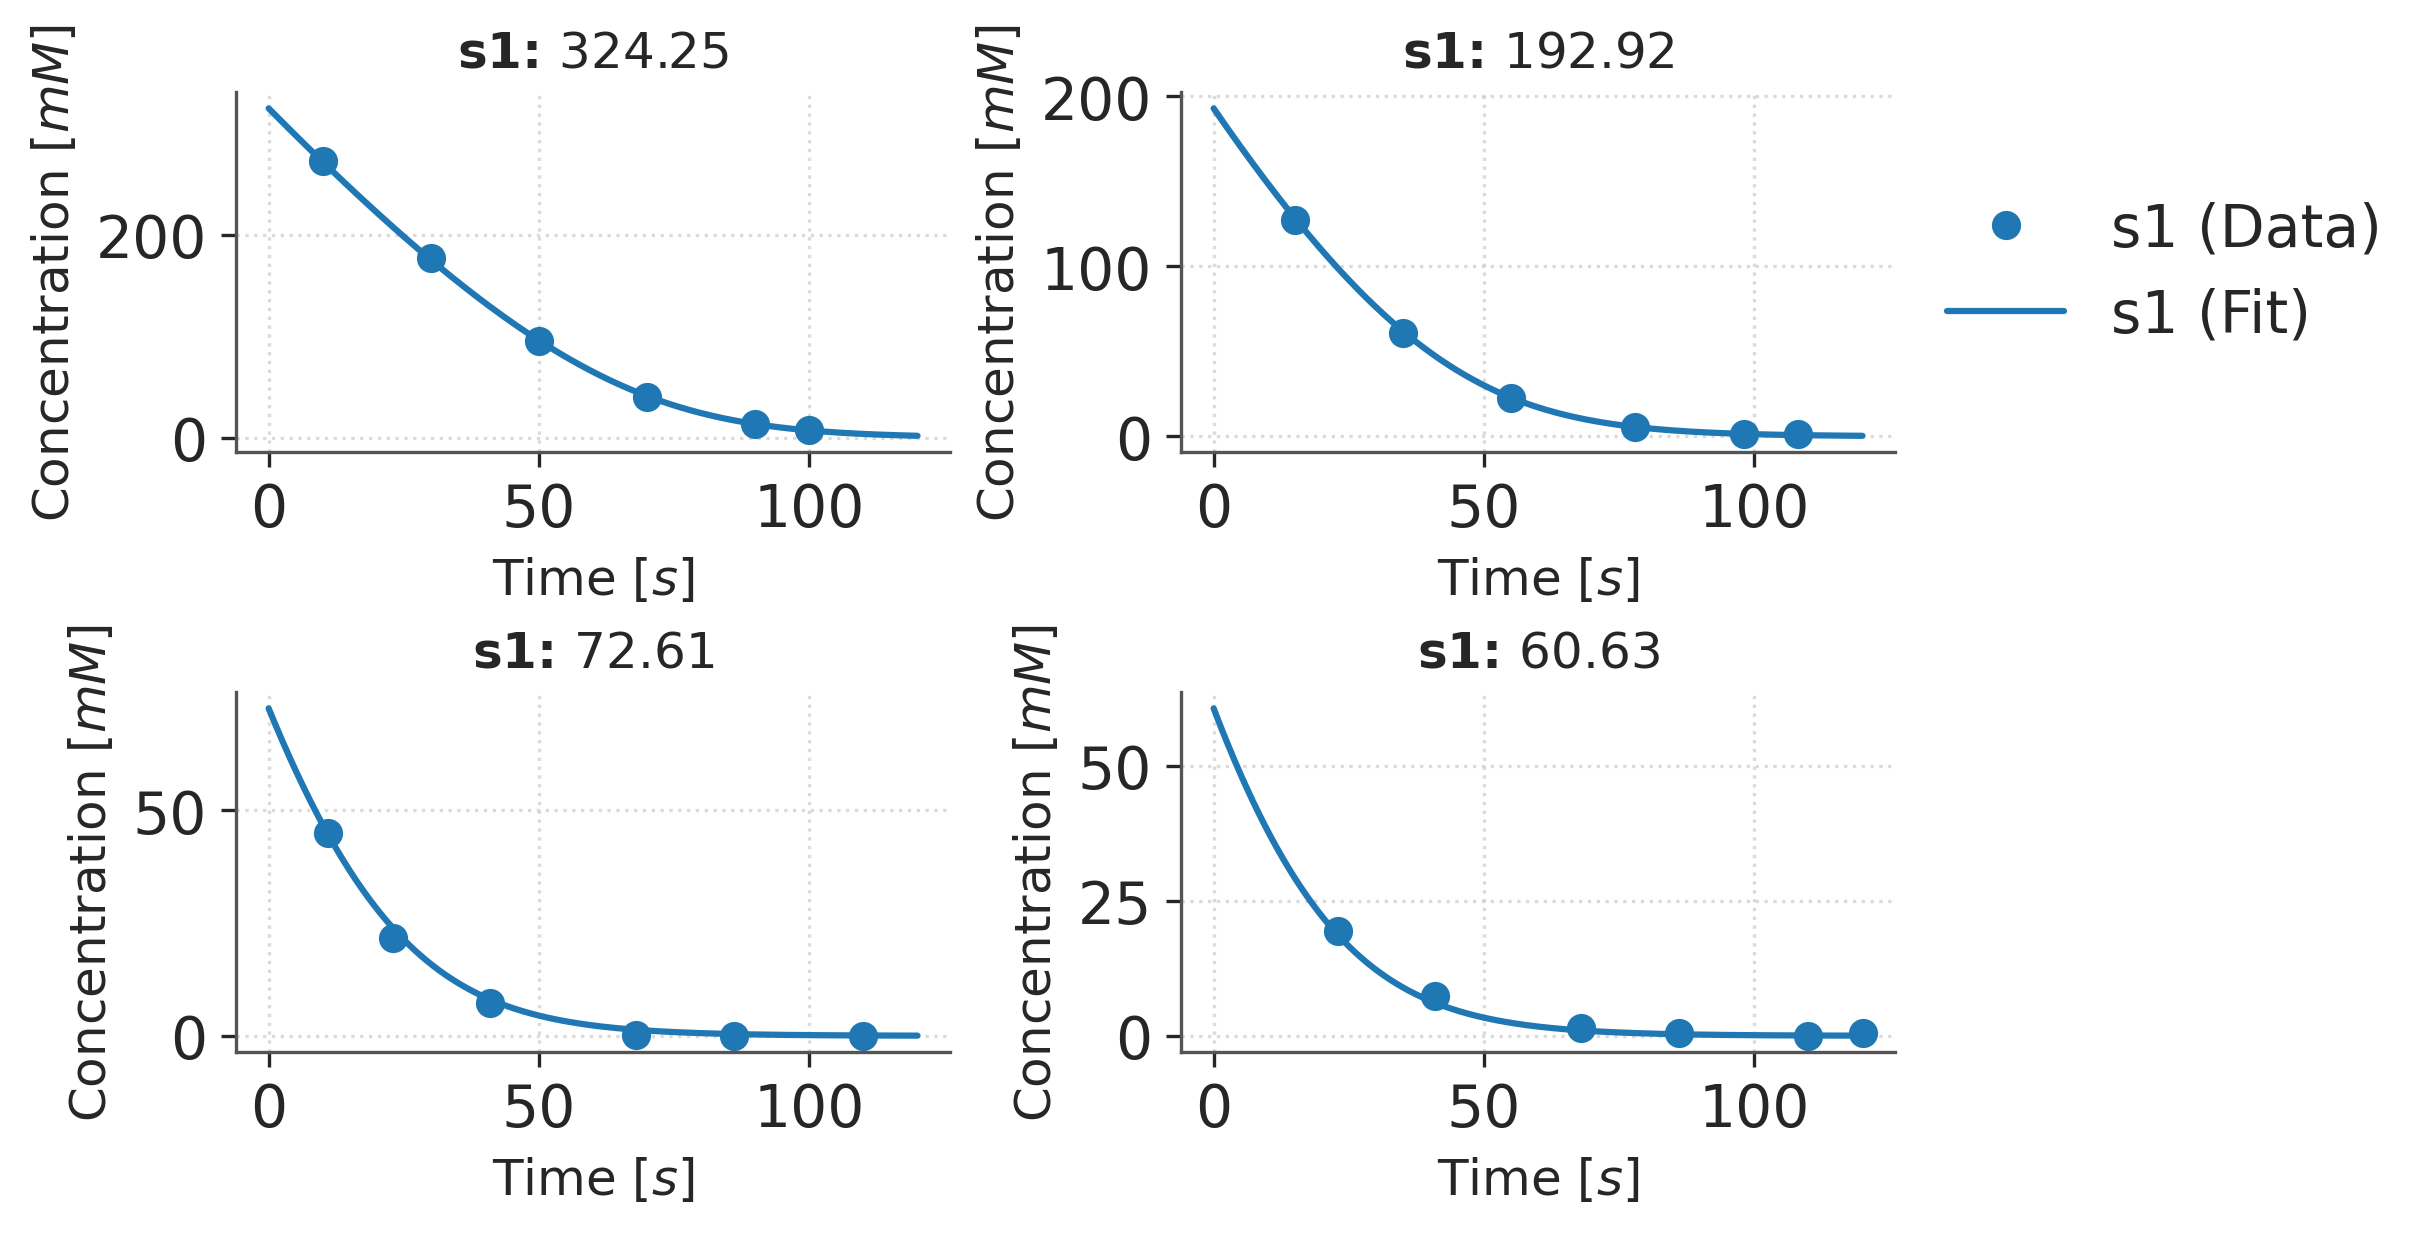

In [8]:
f = ctx.visualize(
    model=new_model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)